# COVID-19論文の分析

このチャレンジでは、COVIDパンデミックのテーマを引き続き取り上げ、関連する科学論文の処理に焦点を当てます。[CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)には、COVIDに関する7000以上（執筆時点）の論文が、メタデータや要約とともに提供されています。（そのうち約半数には全文も含まれています。）

[Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum)認知サービスを使用してこのデータセットを分析する完全な例は、[このブログ記事](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/)で説明されています。ここでは、この分析の簡略版について議論します。


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## データの取得

まず、作業対象となるCORD論文のメタデータを取得する必要があります。

**NOTE**: このリポジトリにはデータセットのコピーは含まれていません。最初に[`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv)ファイルを[こちらのKaggleデータセット](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)からダウンロードする必要があります。Kaggleへの登録が必要な場合があります。また、登録なしで[こちら](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html)からデータセットをダウンロードすることも可能ですが、メタデータファイルに加えてすべての全文が含まれます。

オンラインソースから直接データを取得しようとしますが、失敗した場合は、上記の手順に従ってデータをダウンロードする必要があります。また、さらに実験を行う予定がある場合は、待ち時間を節約するためにデータをダウンロードしておくのが理にかなっています。

> **NOTE** データセットは非常に大きく、約1GBのサイズがあり、以下のコード行の実行にはかなりの時間がかかる可能性があります！（約5分）


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

私たちは現在、出版日列を`datetime`に変換し、出版日の範囲を確認するためにヒストグラムをプロットします。


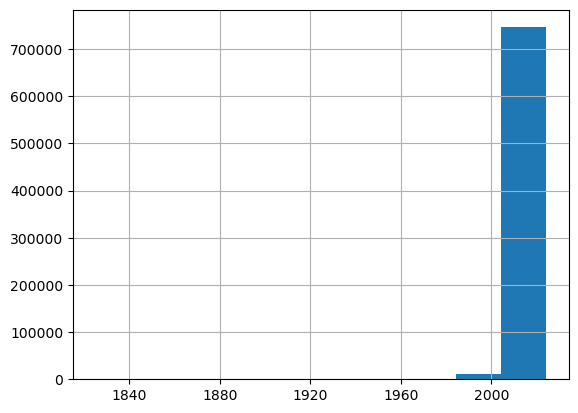

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## 構造化データの抽出

要旨から簡単に抽出できる情報を見てみましょう。興味深い点の一つは、どのような治療戦略が存在し、それが時間とともにどのように進化してきたかを確認することです。まず、COVIDの治療に使用される可能性のある薬剤のリストと診断のリストを手動で作成します。その後、それらを確認し、論文の要旨内で対応する用語を検索します。


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


私たちは、データフレームにいくつかの列を追加しました。これらの列には、特定の薬剤や診断がアブストラクト内で出現した回数が含まれています。

> **Note** アブストラクト内で部分文字列を検索する際、単語の先頭にスペースを追加しています。これを行わないと、誤った結果が得られる可能性があります。例えば、*chloroquine* は *hydroxychloroquine* の中にも見つかってしまうからです。また、エラーを回避するために、アブストラクトの列を強制的に `str` に変換しています。`str` を削除してみると、何が起こるか試してみてください。

データを扱いやすくするために、薬剤の出現回数のみを含むサブフレームを抽出し、出現回数の累積値を計算することができます。これにより、最も人気のある薬剤がわかります。


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

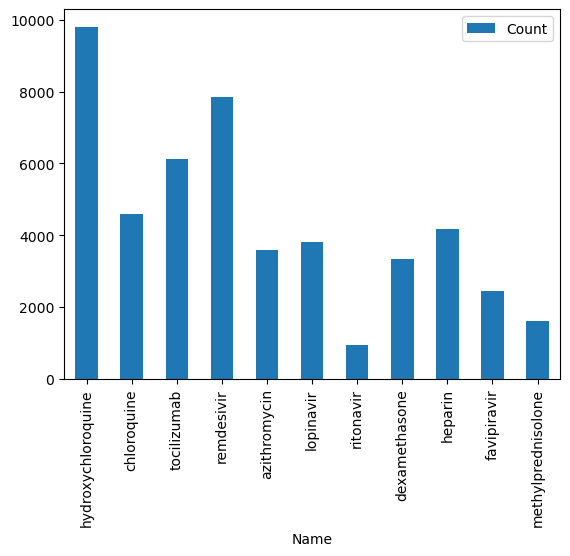

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## 治療戦略の傾向を探る

上記の例では、すべての値を`sum`で合計しましたが、これを月ごとに行うことも可能です:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

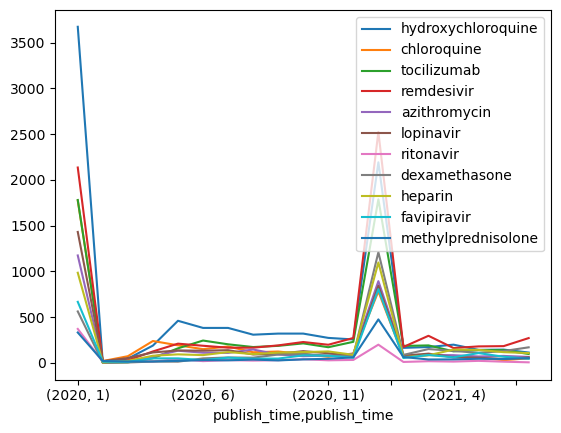

In [152]:
dfmt.plot()
plt.show()

興味深いことに、2020年1月と2021年1月の2つの時点で大きなスパイクが見られます。これは、一部の論文に明確な発行日が指定されておらず、それらが該当する年の1月として指定されているためです。

データをより理解しやすくするために、いくつかの医薬品だけを可視化してみましょう。また、1月のデータを「消去」し、中間的な値で補完することで、より見やすいプロットを作成します。


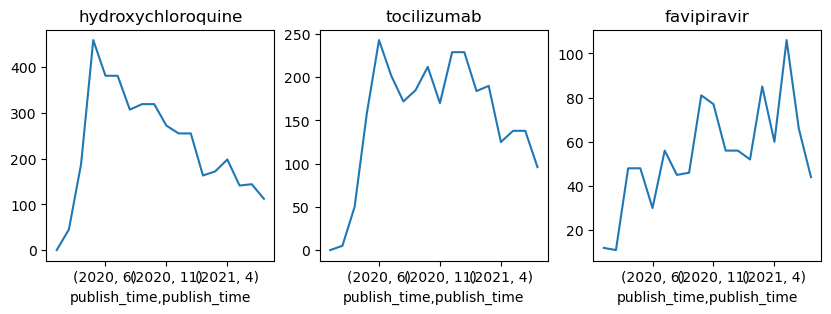

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

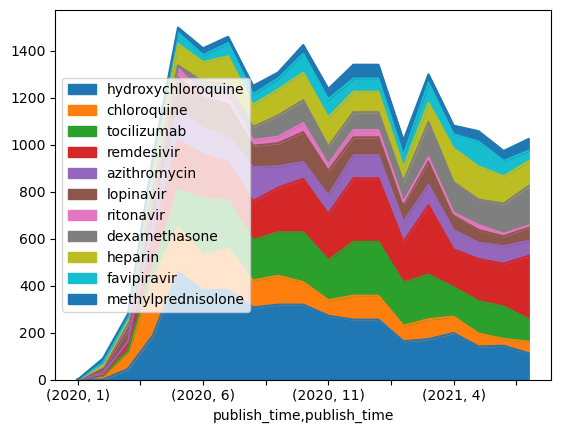

In [154]:
dfmt.plot.area()
plt.show()

さらに、相対的な人気度をパーセントで計算することもできます。


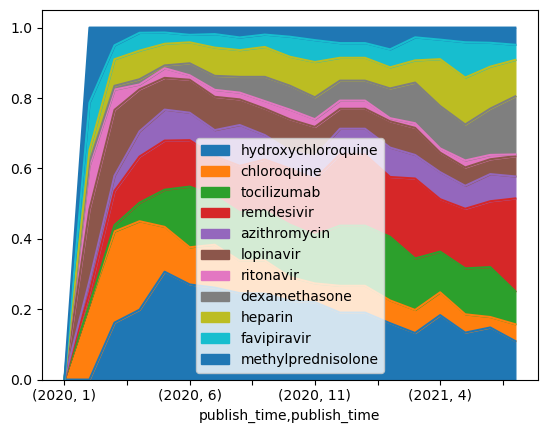

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## 医薬品と診断の対応関係

最も興味深い関係の一つは、異なる診断がどのように異なる薬で治療されるかを調べることです。それを視覚化するためには、**共起頻度マップ**を計算する必要があります。このマップは、2つの用語が同じ論文内で何回言及されているかを示します。

このマップは基本的に2Dマトリックスであり、**numpy array**で表現するのが最適です。このマップを計算するために、すべての要旨を順に確認し、そこに出現するエンティティを記録します。


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

この行列を視覚化する方法の一つは、**ヒートマップ**を描くことです。


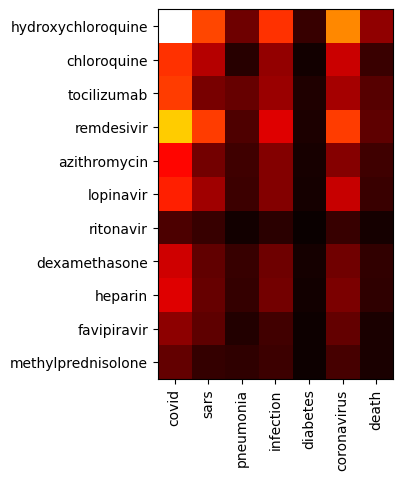

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

しかし、さらに優れた視覚化を行うには、いわゆる**Sankey**ダイアグラムを使用するのが良いでしょう！`matplotlib`にはこのダイアグラムタイプの組み込みサポートがないため、[このチュートリアル](https://plotly.com/python/sankey-diagram/)で説明されているように、[Plotly](https://plotly.com/python/)を使用する必要があります。

PlotlyでSankeyダイアグラムを作成するには、以下のリストを構築する必要があります：
* グラフ内のすべてのノードを含むリスト `all_nodes`。これには、薬剤と診断の両方が含まれます。
* ソースとターゲットのインデックスのリスト - これらのリストは、どのノードが左側に行き、どのノードが右側に行くかを示します。
* すべてのリンクのリスト。各リンクは以下を含みます：
   - `all_nodes`配列内のソースインデックス
   - ターゲットインデックス
   - リンクの強さを示す値。これは、まさに共起行列の値です。
   - 必要に応じてリンクの色。明確さのためにいくつかの用語を強調表示するオプションを作成します。

Sankeyダイアグラムを描画するための汎用コードは、`sankey`関数として構造化されています。この関数は、2つのリスト（ソースとターゲットのカテゴリ）と共起行列を受け取ります。また、しきい値を指定して、そのしきい値より弱いリンクをすべて省略することができます。これにより、ダイアグラムが少しシンプルになります。


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## 結論

非構造化データソース（例えばテキスト）から情報を抽出するために、比較的簡単な方法を使用できることを確認しました。この例では、既存の薬剤リストを使用しましたが、自然言語処理（NLP）技術を活用してテキストからエンティティ抽出を行う方がはるかに強力です。[このブログ記事](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/)では、クラウドサービスを使用してエンティティ抽出を行う方法について説明しています。また、PythonのNLPライブラリを使用する方法もあります。例えば、[NLTK](https://www.nltk.org/)を使用したテキスト情報抽出のアプローチについては[こちら](https://www.nltk.org/book/ch07.html)で説明されています。


## 課題

以下の観点でCOVID関連の論文データを引き続き調査してください：

1. 異なる薬剤の共起行列を作成し、どの薬剤が一緒に出現することが多いか（つまり、1つの要約内で言及されているか）を確認します。薬剤や診断の共起行列を作成するコードを修正しても構いません。
1. この行列をヒートマップで可視化します。
1. 発展的な目標として、[コードダイアグラム](https://en.wikipedia.org/wiki/Chord_diagram)を使用して薬剤の共起を可視化することを検討してください。[このライブラリ](https://pypi.org/project/chord/)がコードダイアグラムの作成に役立つかもしれません。
1. さらに発展的な目標として、正規表現を使用して異なる薬剤の用量（例：*chloroquineを1日400mg服用*の**400mg**など）を抽出し、異なる薬剤の用量を示すデータフレームを作成してみてください。**注意**：薬剤名の近くにある数値を考慮してください。



---

**免責事項**:  
この文書は、AI翻訳サービス [Co-op Translator](https://github.com/Azure/co-op-translator) を使用して翻訳されています。正確性を追求しておりますが、自動翻訳には誤りや不正確な部分が含まれる可能性があります。元の言語で記載された文書が正式な情報源とみなされるべきです。重要な情報については、専門の人間による翻訳を推奨します。この翻訳の使用に起因する誤解や誤解釈について、当方は責任を負いません。
